## Библиотеки и т д

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

keras = tf.keras

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!gsutil cp -r gs://energy_meters_dataset/blur_dataset_v10.zip ./

Copying gs://energy_meters_dataset/blur_dataset_v10.zip...
| [1 files][  3.2 GiB/  3.2 GiB]   12.2 MiB/s                                   
Operation completed over 1 objects/3.2 GiB.                                      


In [0]:
!unzip -q /content/blur_dataset_v10.zip

In [0]:
from PIL import Image
from pathlib import Path

In [0]:
DIR = Path('/content/blur_dataset_v10')
image_file = sorted(list(DIR.rglob('*.jpg')))

In [0]:
!mkdir  -p blur-dataset-new/train/defocused_blurred
!mkdir blur-dataset-new/train/motion_blurred
!mkdir blur-dataset-new/train/sharp
!mkdir blur-dataset-new/train/torch

In [0]:
!mkdir  -p blur-dataset-new/val/defocused_blurred
!mkdir blur-dataset-new/val/motion_blurred
!mkdir blur-dataset-new/val/sharp
!mkdir blur-dataset-new/val/torch

In [0]:
for path_image in image_file:
  try:
    img=Image.open(path_image)
    resized_image = img.resize((224,224))
    resized_image.save('blur-dataset-new'+str(path_image)[25:])
  except OSError:
    img=Image.open(path_image)
    rgb_image = img.convert('RGB')
    resized_image = rgb_image.resize((224,224))
    resized_image.save('blur-dataset-new'+str(path_image)[25:])

In [0]:
!rm -rf /content/blur_dataset_v10

In [0]:
!rm /content/blur_dataset_v10.zip

## Датасет

In [0]:
train_dataset = "/content/blur-dataset-new/train"
val_dataset = "/content/blur-dataset-new/val"

In [0]:
img_height, img_width = 224, 224
batch_size = 200

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True,
    vertical_flip = True,
    #brightness_range=[0.2,1.0],
    #zoom_range=[0.5,1.0]
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True
)

train_datagen.mean = np.array([0.485, 0.456, 0.406]) 
train_datagen.std =  np.array([0.229, 0.224, 0.225])

valid_datagen.mean = np.array([0.485, 0.456, 0.406]) 
valid_datagen.std = np.array([0.229, 0.224, 0.225])

train_generator = train_datagen.flow_from_directory(
    train_dataset,
    shuffle=True,
    color_mode="rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = valid_datagen.flow_from_directory(
    val_dataset, # same directory as training data
    shuffle=True,
    color_mode="rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data


Using TensorFlow backend.


Found 1323 images belonging to 4 classes.
Found 1315 images belonging to 4 classes.


In [0]:
def scheduler(epoch,lr):
  if epoch % 9:
    return lr
  else:
    return lr * 0.7

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

filepath="/content/drive/My Drive/efc_110k_weights.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

## Show set

In [0]:
from pathlib import Path
train_image = Path('/content/BLUR_DATASETV6/blur-datasetv2/val/torch')
val_image = Path(val_dataset)

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(16,16))
  for n in range(16):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      #plt.title(TRAIN_CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [0]:
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)
image_batch.shape

## Сборная сетка - 92к парметров

In [0]:
import tensorflow 
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, ZeroPadding2D, \
Input, AveragePooling2D, Flatten, Dense, Add, DepthwiseConv2D, SeparableConv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform

In [0]:
def identity_block(X, f, filters, stage, block):
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = SeparableConv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = GlorotUniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = SeparableConv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = GlorotUniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = SeparableConv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = GlorotUniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [0]:
def convolutional_block(X, f, filters, stage, block, s=2):

    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = SeparableConv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=GlorotUniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = SeparableConv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=GlorotUniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = SeparableConv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=GlorotUniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = SeparableConv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=GlorotUniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [0]:
def QualityModel_v1(input_shape = (224, 224, 3), classes = 3):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = SeparableConv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = GlorotUniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')


    X = Conv2D(3, (3, 3), padding="same", activation="relu")(X)
    # AVGPOOL
    X = GlobalAveragePooling2D()(X)

    # Output layer
    X = Flatten()(X)

    #remove dense later
    #X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = GlorotUniform(seed=0))(X)
    X = Activation('sigmoid', name="quality_output3")(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='QualityModel_v1')

    return model

Model: "QualityModel_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (SeparableConv2D)         (None, 128, 128, 64) 403         zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
____________________________________________________________________________________

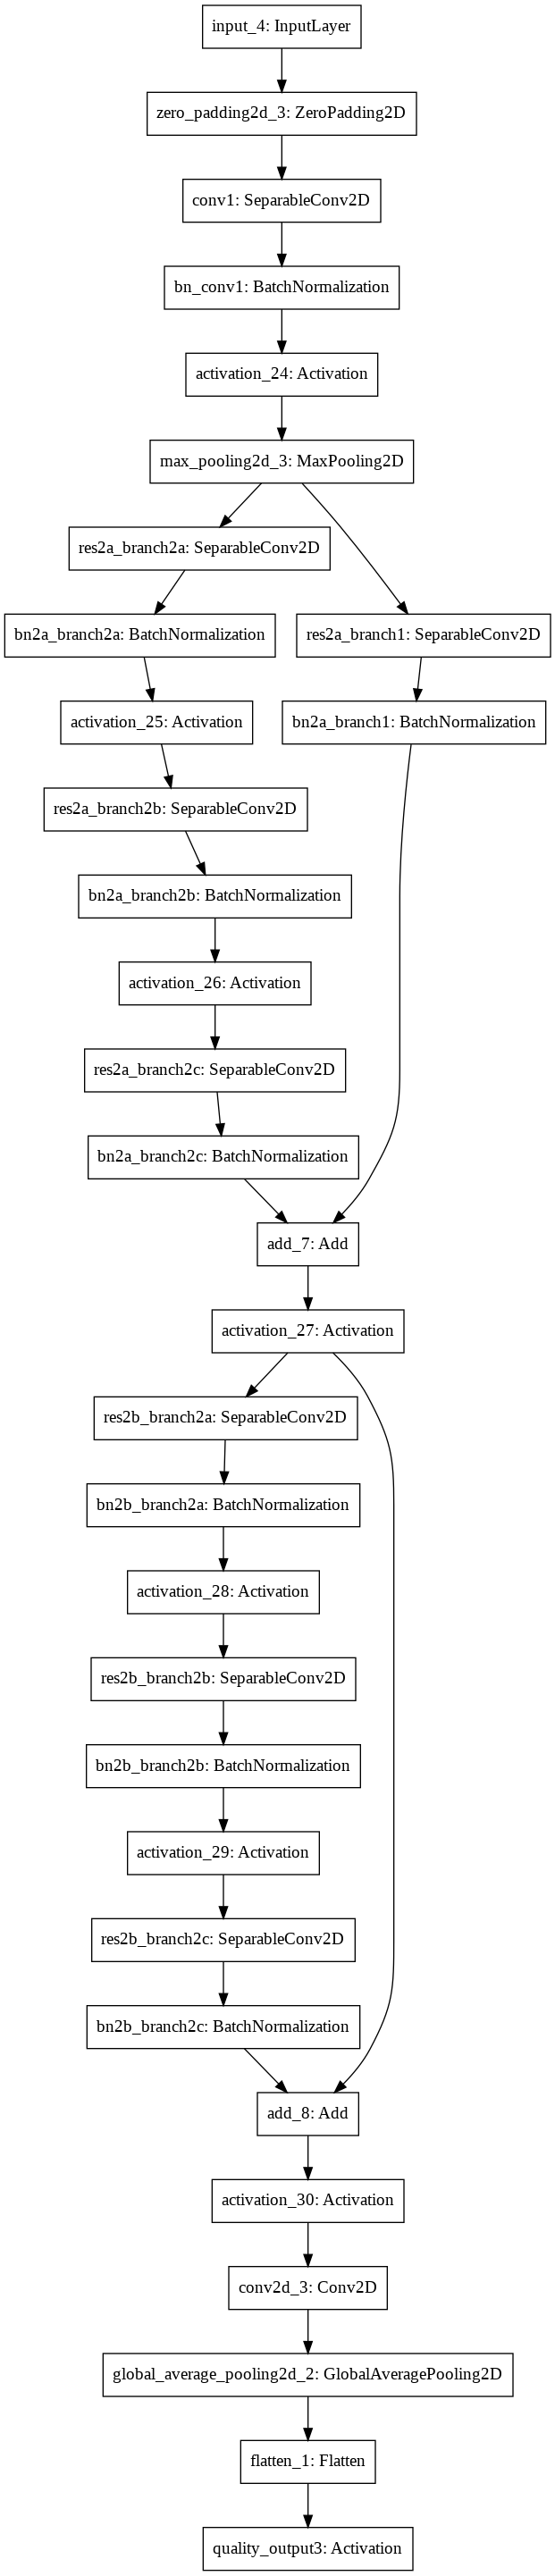

In [0]:
model_branch = QualityModel_v1(input_shape = (256, 256, 3), classes = 3)
model_branch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_branch.summary()
tensorflow.keras.utils.plot_model(model_branch)

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model_branch.layers))

# Fine-tune from this layer onwards
fine_tune_at = 32

# Freeze all the layers before the `fine_tune_at` layer
for layer in model_branch.layers[:fine_tune_at]:
  layer.trainable =  True

Number of layers in the base model:  32


In [0]:
model_branch.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 40,
    callbacks=[callback,checkpoint])

Train for 21 steps, validate for 5 steps
Epoch 1/40
20/21 [===========================>..] - ETA: 9s - loss: 1.0179 - accuracy: 0.5512 
Epoch 00001: val_accuracy improved from -inf to 0.35000, saving model to weights.best.hdf5
21/21 [==============================] - 205s 10s/step - loss: 1.0151 - accuracy: 0.5571 - val_loss: 1.0976 - val_accuracy: 0.3500
Epoch 2/40
20/21 [===========================>..] - ETA: 8s - loss: 0.9608 - accuracy: 0.5950 
Epoch 00002: val_accuracy did not improve from 0.35000
21/21 [==============================] - 204s 10s/step - loss: 0.9602 - accuracy: 0.5964 - val_loss: 1.0950 - val_accuracy: 0.3500
Epoch 3/40
18/21 [========================>.....] - ETA: 27s - loss: 0.9328 - accuracy: 0.6750

## Мобайлнет

In [0]:
mobile_net =  keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
mobile_net.trainable=True

In [0]:
mobile_net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1024, activation = 'relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(3, activation = 'sigmoid')])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 3075      
Total params: 4,285,635
Trainable params: 4,261,699
Non-trainable params: 23,936
_______________________________________

In [0]:
model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 40,
    callbacks=[callback,checkpoint])

Train for 21 steps, validate for 5 steps
Epoch 1/40
20/21 [===========================>..] - ETA: 8s - loss: 0.6462 - accuracy: 0.7350 
Epoch 00001: val_accuracy improved from -inf to 0.68500, saving model to weights.best.hdf5
21/21 [==============================] - 203s 10s/step - loss: 0.6287 - accuracy: 0.7429 - val_loss: 0.7533 - val_accuracy: 0.6850
Epoch 2/40
20/21 [===========================>..] - ETA: 8s - loss: 0.2560 - accuracy: 0.9162 
Epoch 00002: val_accuracy improved from 0.68500 to 0.80500, saving model to weights.best.hdf5
21/21 [==============================] - 198s 9s/step - loss: 0.2602 - accuracy: 0.9167 - val_loss: 0.8393 - val_accuracy: 0.8050
Epoch 3/40
20/21 [===========================>..] - ETA: 8s - loss: 0.1404 - accuracy: 0.9538 
Epoch 00003: val_accuracy did not improve from 0.80500
21/21 [==============================] - 199s 9s/step - loss: 0.1472 - accuracy: 0.9500 - val_loss: 2.3506 - val_accuracy: 0.5900
Epoch 4/40
20/21 [=========================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


KeyboardInterrupt: ignored

##MobileNetV3


###From github

In [0]:
!git clone https://github.com/Bisonai/mobilenetv3-tensorflow /content/MobileNetV3

Cloning into '/content/MobileNetV3'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 67 (delta 36), reused 53 (delta 25), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [0]:
!cp -r /content/MobileNetV3/* /content/

In [0]:
!rm -rf /content/MobileNetV3

In [0]:
from mobilenetv3_small import MobileNetV3

In [0]:
model = MobileNetV3(
    num_classes = 4,
    width_multiplier = 1.0
)

In [0]:
inputs = tf.keras.layers.Input(shape = (224, 224, 3))
outputs = model(inputs)
mbl_model = tf.keras.Model(
        inputs = inputs,
        outputs = outputs,
    )

In [0]:
mbl_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobileNetV3_Small (MobileNet (None, 4)                 1674636   
Total params: 1,674,636
Trainable params: 1,662,492
Non-trainable params: 12,144
_________________________________________________________________


In [0]:
mbl_model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ["accuracy"])

In [0]:
checkpoint = ModelCheckpoint("mbl_net_v3_4.2m_ weights.best.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [0]:
mbl_model.fit_generator(
    train_generator,
    validation_data = validation_generator,
    epochs = 40,
    callbacks = [callback, checkpoint]
)

###Переписанный с github



In [0]:
def _make_divisible(v, divisor, min_value=None):
    """https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)

    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor

    return new_v

In [0]:
class ReLU6(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.relu6 = tf.keras.layers.ReLU(max_value=6)

    def call(self, input):
        return self.relu6(input)


class HardSigmoid(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.relu6 = ReLU6()

    def call(self, input):
        return self.relu6(input + 3.0) / 6.0


class HardSwish(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.hard_sigmoid = HardSigmoid()

    def call(self, input):
        return input * self.hard_sigmoid(input)

In [0]:
def build_model(
    input_shape=(224, 224, 3),
    num_classes=4,
    width_multiplier=1.0,
    divisible_by=8
):
    input_data = tf.keras.layers.Input(name = 'input_layer', shape = input_shape, dtype = 'float32')

    inner = tf.keras.layers.ZeroPadding2D(padding=1)(input_data)

    inner = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, use_bias=False,
                                     kernel_regularizer=tf.keras.regularizers.l2(1e-5))(inner)
    inner = tf.keras.layers.BatchNormalization()(inner)
    inner = HardSwish()(inner)
    
    bneck_settings = [
            # k   exp   out   SE      NL         s
            [ 3,  16,   16,   False,  "relu",    1 ],
            [ 3,  64,   24,   False,  "relu",    2 ],
            [ 3,  72,   24,   False,  "relu",    1 ],
            [ 5,  72,   40,   True,   "relu",    2 ],
            [ 5,  120,  40,   True,   "relu",    1 ],
            [ 5,  120,  40,   True,   "relu",    1 ],
            [ 3,  240,  80,   False,  "hswish",  2 ],
            [ 3,  200,  80,   False,  "hswish",  1 ],
            [ 3,  184,  80,   False,  "hswish",  1 ],
            [ 3,  184,  80,   False,  "hswish",  1 ],
            [ 3,  480,  112,  True,   "hswish",  1 ],
            [ 3,  672,  112,  True,   "hswish",  1 ],
            [ 5,  672,  160,  True,   "hswish",  2 ],
            [ 5,  960,  160,  True,   "hswish",  1 ],
            [ 5,  960,  160,  True,   "hswish",  1 ],
        ]

    for idx, (k, exp, out, SE, NL, s) in enumerate(bneck_settings):
        x = inner
        in_channels = int(inner.shape[3])
        out_channels = _make_divisible(out * width_multiplier, divisible_by)
        exp_channels = _make_divisible(exp * width_multiplier, divisible_by)


        inner = tf.keras.layers.Conv2D(filters=exp_channels, kernel_size=1, use_bias=False,
                                            kernel_regularizer=tf.keras.regularizers.l2(1e-5))(inner)
        inner = tf.keras.layers.BatchNormalization()(inner)
        if(NL == 'hswish'):
            inner = HardSwish()(inner)
        else:
            inner = keras.layers.ReLU()(inner)
        

        inner = tf.keras.layers.ZeroPadding2D(padding=(k - 1) // 2)(inner)
        inner = tf.keras.layers.DepthwiseConv2D(kernel_size=k, strides=s,
                                                    depthwise_regularizer=tf.keras.regularizers.l2(1e-5),
                                                    use_bias=False)(inner)
        inner = tf.keras.layers.BatchNormalization()(inner)


        if(SE == True):
            inner2 = tf.keras.layers.AveragePooling2D(pool_size=tuple(map(int, inner.shape[1:3])))(inner)
            

            inner2 = tf.keras.layers.Conv2D(filters=exp_channels // 4, kernel_size=1, use_bias=False,
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-5))(inner2)
            inner2 = tf.keras.layers.ReLU()(inner2)


            inner2 = tf.keras.layers.Conv2D(filters=exp_channels, kernel_size=1, use_bias=False,
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-5))(inner2)
            inner2 = HardSigmoid()(inner2)

            inner += inner2

        
        if(NL == 'hswish'):
            inner = HardSwish()(inner)
        else:
            inner = keras.layers.ReLU()(inner)
        

        inner = tf.keras.layers.Conv2D(filters=out_channels, kernel_size=1, use_bias=False,
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-5))(inner)
        inner = tf.keras.layers.BatchNormalization()(inner)


        if((in_channels == out_channels) and (s == 1)):
            inner += x

    
    penultimate_channels = _make_divisible(960 * width_multiplier, divisible_by)
    last_channels = _make_divisible(1280 * width_multiplier, divisible_by)

    inner = tf.keras.layers.Conv2D(filters=penultimate_channels, kernel_size=1, use_bias=False,
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-5))(inner)
    inner = tf.keras.layers.BatchNormalization()(inner)
    inner = HardSwish()(inner)


    inner = tf.keras.layers.AveragePooling2D(pool_size=tuple(map(int, inner.shape[1:3])))(inner)


    inner = tf.keras.layers.Conv2D(filters=last_channels, kernel_size=1,
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-5))(inner)
    inner = HardSwish()(inner)


    inner = tf.keras.layers.Dropout(0.2)(inner)


    inner = tf.keras.layers.Conv2D(filters=num_classes, kernel_size=1,
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-5))(inner)
    inner = tf.keras.layers.Softmax()(inner)


    inner = tf.keras.backend.squeeze(inner, 1)
    outputs = tf.keras.backend.squeeze(inner, 1)

    return tf.keras.Model(inputs=input_data, outputs=outputs)

In [0]:
mbl_model = build_model()

In [21]:
mbl_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 226, 226, 3)  0           input_layer[0][0]                
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 16) 432         zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 16) 64          conv2d[0][0]                     
______________________________________________________________________________________________

In [0]:
mbl_model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ["accuracy"])

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("mbl_net_v3_4.2m_weights.best.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

####MNIST, CIFAR



In [0]:
mbl_modelc = build_model(input_shape=(32, 32, 3), num_classes=100)

In [0]:
mbl_modelc.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ["accuracy"])

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [0]:
import numpy as np

In [0]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [0]:
x_train = x_train.astype(np.float32) / 255
y_train = tf.one_hot(y_train, 100)
y_train = tf.keras.backend.squeeze(y_train, 1)

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.repeat()
dataset = dataset.shuffle(10000)

In [0]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), TensorShape([50000, 100]))

In [0]:
mbl_modelc.fit(x_train,
              y_train,
              validation_split=0.15,
              epochs=40,
              batch_size=batch_size,
)

Epoch 1/40


ValueError: ignored

####OurDataset


In [0]:
mbl_model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 40,
    callbacks=[callback,checkpoint]
)

Epoch 1/40
6/6 [==============================] - ETA: 0s - loss: 1.3836 - accuracy: 0.4183
Epoch 00001: val_accuracy improved from -inf to 0.13417, saving model to /content/drive/My Drive/efc_110k_weights.best.hdf5
6/6 [==============================] - 12s 2s/step - loss: 1.3836 - accuracy: 0.4183 - val_loss: 2.0091 - val_accuracy: 0.1342 - lr: 4.9000e-04
Epoch 2/40
6/6 [==============================] - ETA: 0s - loss: 1.2196 - accuracy: 0.5423
Epoch 00002: val_accuracy did not improve from 0.13417
6/6 [==============================] - 10s 2s/step - loss: 1.2196 - accuracy: 0.5423 - val_loss: 1.9136 - val_accuracy: 0.1333 - lr: 4.9000e-04
Epoch 3/40
6/6 [==============================] - ETA: 0s - loss: 1.1287 - accuracy: 0.5601
Epoch 00003: val_accuracy improved from 0.13417 to 0.13583, saving model to /content/drive/My Drive/efc_110k_weights.best.hdf5
6/6 [==============================] - 10s 2s/step - loss: 1.1287 - accuracy: 0.5601 - val_loss: 2.0840 - val_accuracy: 0.1358 - l

KeyboardInterrupt: ignored

####predict


In [0]:
from keras.preprocessing.image import ImageDataGenerator

valid_datagen = ImageDataGenerator(
    rescale=1./255
)

#valid_datagen.mean = np.array([0.485, 0.456, 0.406]) 
#valid_datagen.std =  np.array([0.229, 0.224, 0.225])

validation_generator = train_datagen.flow_from_directory(
    val_dataset, # same directory as training data
    shuffle=False,
    color_mode="rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 1315 images belonging to 4 classes.


In [0]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = mbl_model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)
print('Classification Report')
target_names = ['defocus','motion_blured', 'sharp', 'torch']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

KeyboardInterrupt: ignored

## efficientnet

In [0]:
pip install -U efficientnet

In [0]:
import efficientnet.tfkeras as efn 

In [0]:
model_efficient = efn.EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
model_efficient.trainable=True

16809984/16804768 [==============================] - 2s 0us/step


Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

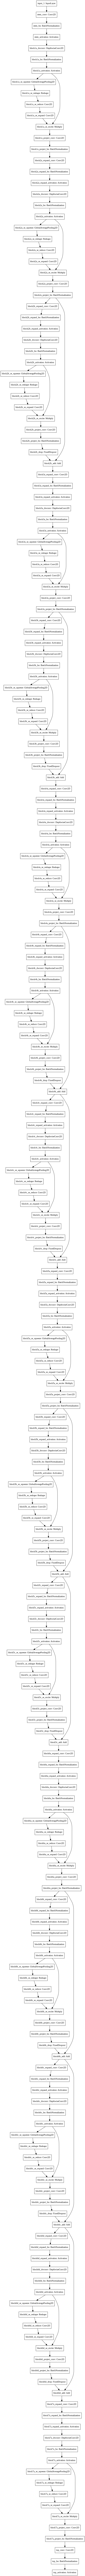

In [0]:
model_efficient.summary()
tf.keras.utils.plot_model(model_efficient)

In [0]:
c = 0
for i in model_efficient.layers:
  print(c,i)
  c += 1

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f872c68b5f8>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f872c68bb38>
2 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f872c68bef0>
3 <tensorflow.python.keras.layers.core.Activation object at 0x7f872c624ba8>
4 <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f872c624470>
5 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f872c624908>
6 <tensorflow.python.keras.layers.core.Activation object at 0x7f872be90cf8>
7 <tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f872be97550>
8 <tensorflow.python.keras.layers.core.Reshape object at 0x7f872be97048>
9 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f872be39d30>
10 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f872be41dd8>
11 <tensorflow.python.keras.layers.merge.Multiply object at 0x7f872be4a668>

In [0]:
inp = model_efficient.inputs[0]
out = model_efficient.layers[103].output

In [0]:
model = tf.keras.models.Model(inputs=inp, outputs=out)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

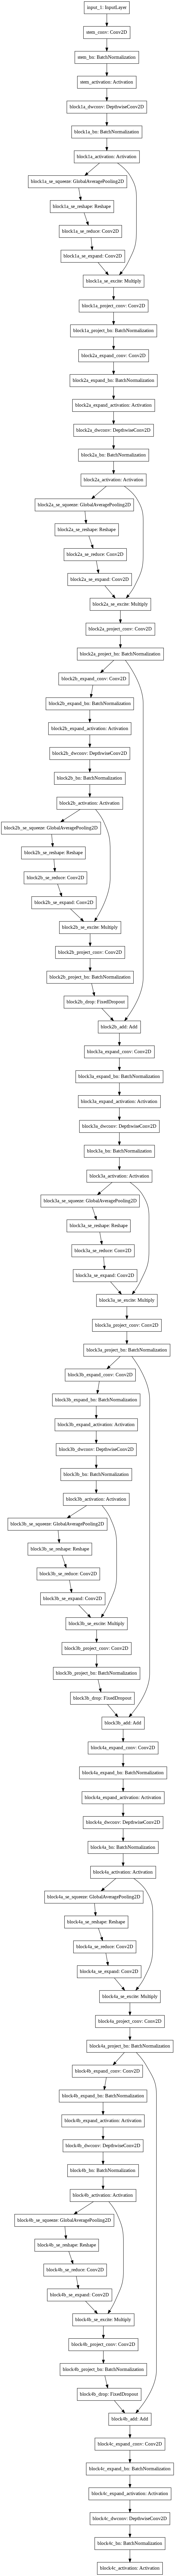

In [0]:
model.summary()
tf.keras.utils.plot_model(model)

In [0]:
model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  #tf.keras.layers.Dense(1024, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(4, activation = 'sigmoid')])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

In [0]:
model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 40,
    callbacks=[callback,checkpoint])

Train for 37 steps, validate for 7 steps
Epoch 1/40
36/37 [============================>.] - ETA: 6s - loss: 1.3730 - accuracy: 0.3382 

## Матрица ошибок

In [0]:
model.load_weights('/content/drive/My Drive/efc_110k_weights.best.hdf5')

In [0]:
from keras.preprocessing.image import ImageDataGenerator

valid_datagen = ImageDataGenerator(
    rescale=1./255
)

#valid_datagen.mean = np.array([0.485, 0.456, 0.406]) 
#valid_datagen.std =  np.array([0.229, 0.224, 0.225])

validation_generator = train_datagen.flow_from_directory(
    val_dataset, # same directory as training data
    shuffle=False,
    color_mode="rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')# set as validation data

Found 302 images belonging to 4 classes.


In [0]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)
print('Classification Report')
target_names = ['defocus','motion_blured', 'sharp', 'torch']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
Classification Report
               precision    recall  f1-score   support

      defocus       0.93      0.97      0.95        87
motion_blured       0.92      0.87      0.89        63
        sharp       0.63      0.90      0.74        63
        torch       0.92      0.63      0.75        89

     accuracy                           0.83       302
    macro avg       0.85      0.84      0.83       302
 weighted avg       0.86      0.83      0.83       302



In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
   

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

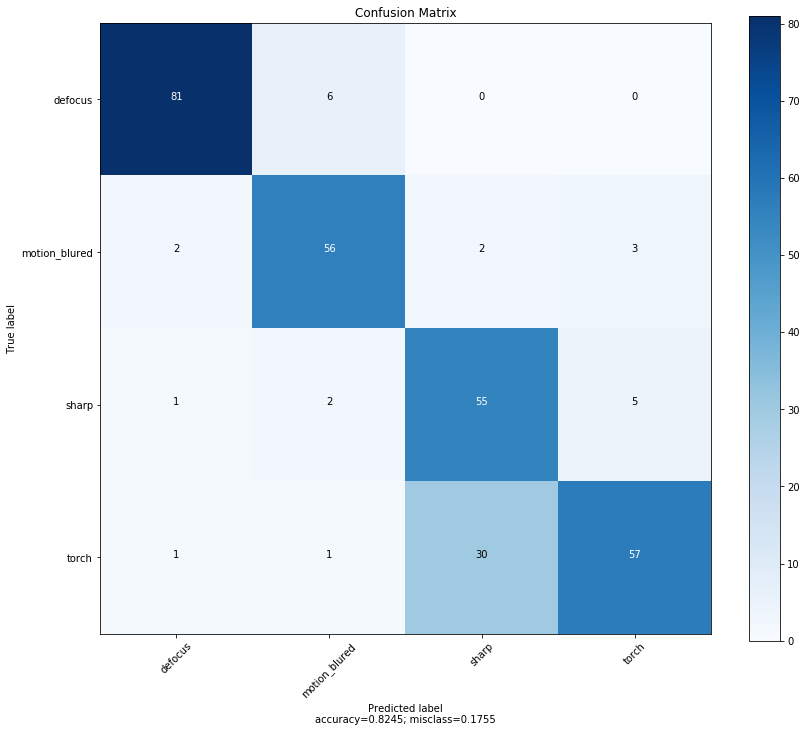

In [0]:
plot_confusion_matrix(cnf_matrix, 
                      normalize    = False,
                      target_names =  target_names,
                      title        = "Confusion Matrix")

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True,
    vertical_flip = True,
    #brightness_range=[0.2,1.0],
    #zoom_range=[0.5,1.0],
    validation_split=0.2
)


train_datagen.mean = np.array([0.485, 0.456, 0.406]) 
train_datagen.std =  np.array([0.229, 0.224, 0.225])

train_generator = train_datagen.flow_from_directory(
    train_dataset,
    shuffle=True,
    color_mode="rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dataset, # same directory as training data
    shuffle=False,
    color_mode="rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

## lite



## lite 2

In [0]:
import tensorflow_hub as hub

In [0]:
!nvidia-smi

Thu Mar 19 14:14:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
 # это я достал с image_classificate
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[seq_len]),
        tf.keras.layers.Embedding(
            len(self.vocab), wordvec_dim, input_length=seq_len),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(wordvec_dim, activation=tf.nn.relu),
        tf.keras.layers.Dropout(self.dropout_rate),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

NameError: ignored

In [0]:
feature_extractor_url = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/1"

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224, 224, 3))
feature_extractor_layer.trainable = True

In [0]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  #tf.keras.layers.Dense(1024, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(4, activation = 'sigmoid')])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              3413024   
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 3,418,148
Trainable params: 5,124
Non-trainable params: 3,413,024
_________________________________________________________________


In [0]:
model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 40,
    callbacks=[checkpoint])

Train for 37 steps, validate for 7 steps
Epoch 1/40
36/37 [============================>.] - ETA: 0s - loss: 1.3272 - accuracy: 0.4812
Epoch 00001: val_accuracy did not improve from 0.31071
37/37 [==============================] - 11s 308ms/step - loss: 1.3252 - accuracy: 0.4790 - val_loss: 1.4600 - val_accuracy: 0.3107
Epoch 2/40
36/37 [============================>.] - ETA: 0s - loss: 1.2944 - accuracy: 0.4986
Epoch 00002: val_accuracy did not improve from 0.31071
37/37 [==============================] - 11s 310ms/step - loss: 1.2985 - accuracy: 0.5000 - val_loss: 1.4574 - val_accuracy: 0.3107
Epoch 3/40
36/37 [============================>.] - ETA: 0s - loss: 1.1964 - accuracy: 0.5209
Epoch 00003: val_accuracy did not improve from 0.31071
37/37 [==============================] - 11s 309ms/step - loss: 1.1935 - accuracy: 0.5197 - val_loss: 1.4625 - val_accuracy: 0.2393
Epoch 4/40
36/37 [============================>.] - ETA: 0s - loss: 1.0977 - accuracy: 0.5251
Epoch 00004: val_accur

NotImplementedError: ignored